In [1]:
import numpy as np
import tensorflow as tf
np.random.seed(0)
tf.set_random_seed(0)

import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot = True)
n_samples = mnist.train.num_examples

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
def xavier_init(fan_in, fan_out,constant = 1):
    low = -constant*np.sqrt(6.0/(fan_in+fan_out))
    high = constant*np.sqrt(6.0/(fan_in+fan_out))
    return tf.random_uniform((fan_in,fan_out),
                            minval = low, maxval = high,
                            dtype = tf.float32)

In [55]:
class VAE(object):
    def __init__(self, net_arch, lr = 0.001, batch_size = 100,  trans_func = tf.nn.softplus):
        self.lr = lr
        self.batch_size = batch_size
        self.net_arch = net_arch
        self.trans_func = trans_func
        
        self.x  = tf.placeholder(tf.float32, [None, self.net_arch['n_input']])
        
        self._create_network()
        self._create_loss_optimizer()
        
        init = tf.global_variables_initializer()
        
        tf_config = tf.ConfigProto(device_count={"CPU": 2},  # limit to num_cpu_core CPU usage
                            inter_op_parallelism_threads=2,
                            intra_op_parallelism_threads=2,
                            log_device_placement=True)
        tf_config.gpu_options.allow_growth = True
        self.sess = tf.InteractiveSession(config=tf_config)
        
        self.sess.run(init)
    
    def _create_network(self):
        all_weights = self._init_weights(**self.net_arch)
        
        self.z_mean, self.z_std_log_sq = self._encoder(all_weights['weights_encoder'],all_weights['biases_encoder'])
        
        #计算epsilon 和 z
        n_z = self.net_arch['n_z']
        eps = tf.random_normal((self.batch_size,n_z),0,1,dtype=tf.float32)
        self.z = tf.add(self.z_mean, 
                tf.multiply(
                    tf.sqrt(tf.exp(self.z_std_log_sq)),
                    eps)
                )
        
        self.x_rec = self._decoder(all_weights['weights_decoder'],all_weights['biases_decoder'])
        
    def _init_weights(self,n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_encoder'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        all_weights['biases_encoder'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_decoder'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
        all_weights['biases_decoder'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
    
    def _encoder(self,weights,biases):
  
        hidden1 = tf.add(tf.matmul(self.x, weights['h1']),biases['b1'])
        hidden1 = self.trans_func(hidden1)
        
        hidden2 = hidden1 = tf.add(tf.matmul(hidden1, weights['h2']),biases['b2'])
        hidden2 = self.trans_func(hidden2)
        
        z_mean = tf.add(tf.matmul(hidden2,weights['out_mean']),biases['out_mean'])
        z_std_log_sq = tf.add(tf.matmul(hidden2,weights['out_log_sigma']),biases['out_log_sigma'])
        return (z_mean,z_std_log_sq)
    
    def _decoder(self,weights,biases):
       
        hidden1 = tf.add(tf.matmul(self.z, weights['h1']),biases['b1'])
        hidden1 = self.trans_func(hidden1)
        
        hidden2 = hidden1 = tf.add(tf.matmul(hidden1, weights['h2']),biases['b2'])
        hidden2 = self.trans_func(hidden2)
        
        x_rec = tf.add( tf.matmul(hidden2,weights['out_mean']),biases['out_mean'])
        x_rec = tf.nn.sigmoid(x_rec)
        return x_rec
    
    def _create_loss_optimizer(self):
        generative_loss = -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_rec)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_rec),
                           1)
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_std_log_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_std_log_sq), 1)
        self.cost = tf.reduce_mean(generative_loss + latent_loss)
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.lr).minimize(self.cost)
        
    def partial_fit(self,x):
        opt,cost = self.sess.run((self.optimizer,self.cost),feed_dict={self.x:x})
        return cost
    def transform(self,x):
        pass
    def generate(self,z_mu=None):
        if z_mu is None:
            n_z = self.net_arch['n_z']
            z_mu = np.random.normal(size=(self.batch_size,n_z))
        return self.sess.run(self.x_rec,feed_dict={self.z:z_mu})
    def reconstruct(self,x):
        return self.sess.run(self.x_rec,feed_dict={self.x:x})

In [56]:
net_arch = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=20)
vae = VAE(net_arch)

In [57]:
def train(vae, training_epochs = 10, display_step=5):
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / vae.batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(vae.batch_size)

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * vae.batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "cost=", "{:.9f}".format(avg_cost))
train(vae,75)

Epoch: 0001 cost= 175.290066473
Epoch: 0006 cost= 108.949997087
Epoch: 0011 cost= 104.446166742
Epoch: 0016 cost= 102.448384025
Epoch: 0021 cost= 101.130695787
Epoch: 0026 cost= 99.938614918
Epoch: 0031 cost= 99.016375913
Epoch: 0036 cost= 98.322536247
Epoch: 0041 cost= 97.792364682
Epoch: 0046 cost= 97.191232411


KeyboardInterrupt: 

In [52]:
x_rec = vae.generate()
print(x_rec.shape)

(100, 784)


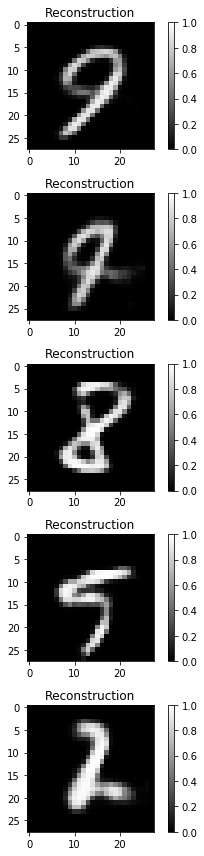

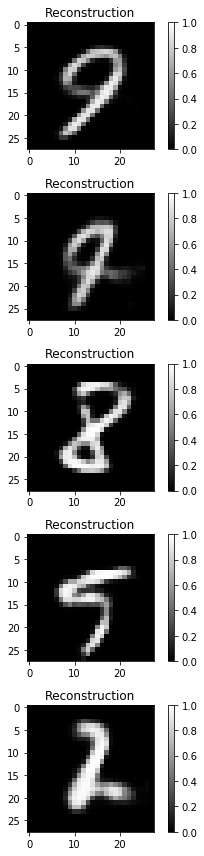

In [2]:
import numpy as np
a = np.zeros((3,4))
b = np.ones((3,4))

In [ ]:
np.sum()